In [1]:
import math
from typing import Annotated, Sequence

import numexpr
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt.tool_node import ToolNode
from typing_extensions import TypedDict


@tool
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )



In [2]:

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tools = [calculator]
llm_with_tools = llm.bind_tools(tools, tool_choice="any")


class ChainState(TypedDict):
    """LangGraph state."""

    messages: Annotated[Sequence[BaseMessage], add_messages]


async def acall_chain(state: ChainState, config: RunnableConfig):
    last_message = state["messages"][-1]
    response = await llm_with_tools.ainvoke(state["messages"], config)
    return {"messages": [response]}


async def acall_model(state: ChainState, config: RunnableConfig):
    response = await llm.ainvoke(state["messages"], config)
    return {"messages": [response]}


In [3]:
graph_builder = StateGraph(ChainState)
graph_builder.add_node("call_tool", acall_chain)
graph_builder.add_node("execute_tool", ToolNode(tools))
graph_builder.add_node("call_model", acall_model)
graph_builder.set_entry_point("call_tool")
graph_builder.add_edge(START, "call_tool")
graph_builder.add_edge("call_tool", "execute_tool")
graph_builder.add_edge("execute_tool", "call_model")
graph_builder.add_edge("call_model", END)
chain = graph_builder.compile()

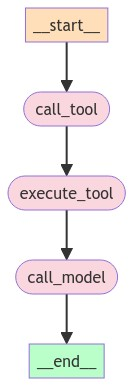

In [4]:
# Visualize chain:

from IPython.display import Image

Image(chain.get_graph().draw_mermaid_png())

In [5]:
chain.invoke("if i have 4563 apples and i get 34567 more apples. then i give someone 678 apple. How many apples will i be left?")

KeyError: '__start__'

In [ ]:
# Stream chain steps:
from langchain_core.messages import BaseMessage, HumanMessage

example_query = "What is 551368 divided by 82"

initial_state = {"messages": [HumanMessage(content=example_query)]}

events = chain.astream(
    {"messages": [("user", example_query)]},
    stream_mode="values",
)
async for event in events:
    event["messages"][-1].pretty_print()

KeyError: '__start__'

In [ ]:
import math
from typing import Annotated, Sequence

import numexpr
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt.tool_node import ToolNode
from typing_extensions import TypedDict


@tool
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tools = [calculator]
llm_with_tools = llm.bind_tools(tools, tool_choice="any")


class ChainState(TypedDict):
    """LangGraph state."""

    messages: Annotated[Sequence[BaseMessage], add_messages]


async def acall_chain(state: ChainState, config: RunnableConfig):
    response = await llm_with_tools.ainvoke(state["messages"], config)
    return {"messages": state["messages"] + [response]}


async def acall_model(state: ChainState, config: RunnableConfig):
    response = await llm.ainvoke(state["messages"], config)
    return {"messages": state["messages"] + [response]}


graph_builder = StateGraph(ChainState)
graph_builder.add_node("call_tool", acall_chain)
graph_builder.add_node("execute_tool", ToolNode(tools))
graph_builder.add_node("call_model", acall_model)
graph_builder.set_entry_point("call_tool")
graph_builder.add_edge("call_tool", "execute_tool")
graph_builder.add_edge("execute_tool", "call_model")
graph_builder.add_edge("call_model", END)
chain = graph_builder.compile()



In [ ]:
# Test the chain with an example query
example_query = "What is 551368 divided by 82"

# Initializing the input state
initial_state = {"messages": [HumanMessage(content=example_query)]}

# Run the chain asynchronously
events = chain.astream(initial_state, stream_mode="values")

async for event in events:
    event["messages"][-1].pretty_print()
